Andrej Karpathy의 Deep Dive into LLMs like ChatGPT (FEB-2025)
https://www.youtube.com/watch?v=7xTGNNLPyMI

# 0. Introduction

ChatGPT와 같은 LLM에 대해서 총망라하면서도 일반 대중을 위한 영상을 만들어보고자 함. 전체 파이프라인을 다룰 것임. 또한 그들의 "심리"에 대해서도 살펴보겠음.

# 1. Pretraining Data (internet)

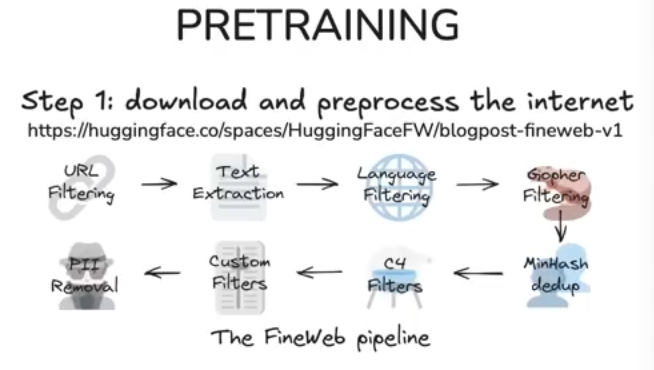

https://huggingface.co/spaces/HuggingFaceFW/blogpost-fineweb-v1

ChatGPT, Anthropic 등 모든 회사는 내부적으로 이런 FineWeb처럼 생긴 방대한 학습용 데이터를 '자체적으로' 보유하고 있음. 
우선, 여기에 나타난 FineWeb을 예로 들자면, 인터넷 데이터는 매우 방대하지만 위 이미지와 같은 적극적인 필터링 절차를 거치고, 텍스트 정보들에만 국한되기 때문에, 결과적으로 44T disk space만을 차지함. 

사전학습을 위한 모든 작업의 시작점은 CommonCrawl (CC) 이라는 비영리단체임. 2007년부터 웹 크롤링을 시작해서, 몇개의 시드 웹페이지로부터 링크를 계속 확장해나가면서 모든 웹사이트를 읽어오게 되었고, 2024.4월 기준으로 27억개의 웹페이지를 크롤링하였음.

FineWeb의 경우
1. URL Filtering : 말웨어, 스팸, 마케팅, 인종차별, 성인물 등 blocklist의 내용은 제외
2. Text Extraction : CC에서는 raw website를 다운로드받았기 때문에, < li > < /li >와 같은 html tag들을 제거하고, 실제 콘텐츠에 해당하는 텍스트만 남기는 작업
3. Language Filtering : 작업마다의 의사결정이 들어가는 부분인데, FineWeb에서는 영문이 65% 이상 차지하는 데이터만 남겼음. (따라서, FineWeb기반으로 학습한 모델은 영어는 잘 하게 되지만, 다른 언어에 대해서는 상대적으로 낮은 성능을 보이게 됨.)
4. 기타 : 그 외 dedup 중복 제거 등 일반적인 과정을 거치고,
   PII (Personally Identifiable Information, 주소 혹은 SSN주민번호와 같은 정보)를 찾아서 제거

* 위 blog 하단에 2022년말 ChatGPT 론칭 이후에 크롤링데이터에서의 AI가 만들어낸 합성 데이터가 늘어나는 것으로 추정하는 데이터가 나와있는 것이 흥미롭습니다. (delve, as a large language model과 같은 표현 빈도의 증가)
그럼에도, 아직 이러한 합성데이터로 인한 성능 하락의 징후는 보이지 않았다-고 밝히고 있습니다. (그리고, might actually improve it 성능이 향상될지도?라고 남기고 있습니다. ^^; )

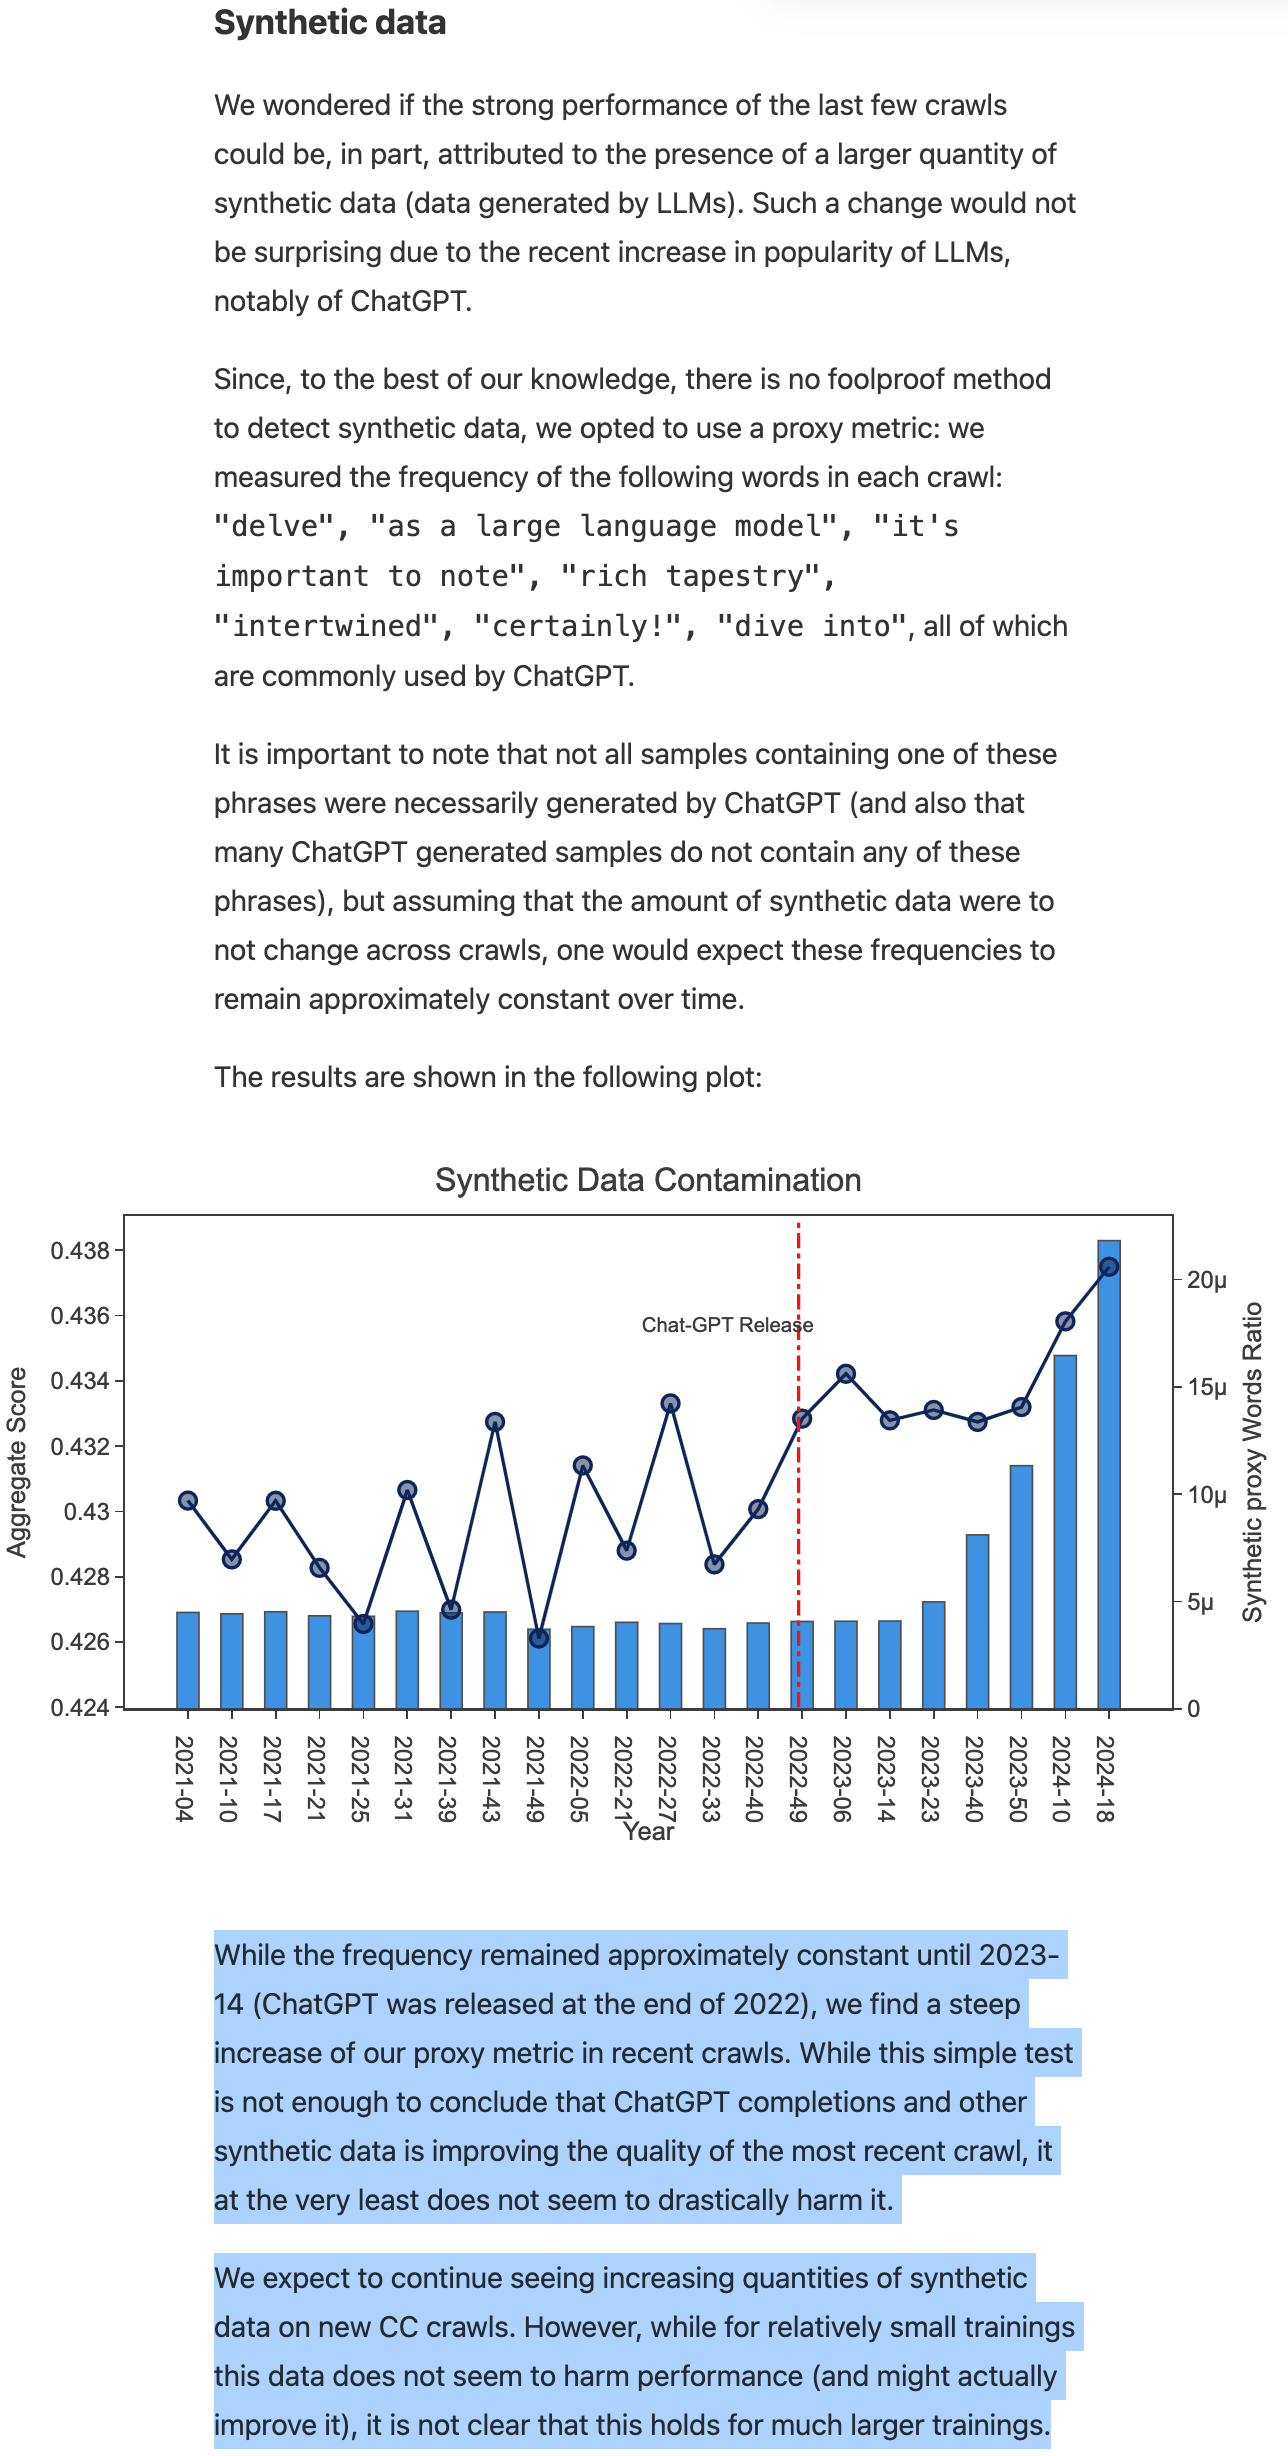

이와 같이 CC에서 시작되어 정제된 FineWeb 데이터를 누구나 다운받을 수 있습니다. (44TB) 
https://huggingface.co/datasets/HuggingFaceFW/fineweb



# 2. Tokenization

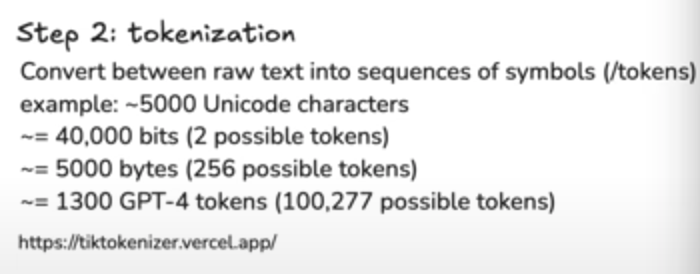

[ "심볼의 개수"와 "시퀀스의 길이" 사이의 Trade-Off ]

* 작년 Tokenizer 강의에서도 그랬고, Andrej Karpathy는 항상 Tokenizer가 실제 언어모델과 사람의 자연어 사이에서 중간적인 역할을 수행함으로써 발생하고 있는 이슈를 언어모델 자체의 문제로 오해하는 것에 대해서 많이 안타까워했고, 이후 트위터에서도 관련 설명들을 보충하려는 노력들을 항상 해왔었는데요, 이번 영상에서도 최대한 이해를 돕기 위해서 쉽게 설명하려는 노력이 보였습니다. 

우선, 우리가 신경망에 텍스트를 집어넣기 전에 이 텍스트를 '어떻게 표현할 것인가 _representation of text data' 라는 부분을 짚어야 합니다.

. 신경망이 인풋으로 "1차원의 심볼로 이루어진 시퀀스"가 들어오기를 기대하고 있으며, (*언어가 선형적이듯이)
. 이 심볼들은 "유한한 숫자_finite"여야 합니다. (*사람도 상호 약속된 기호만 사용하듯이)


1. [TEXT] 예를 들어, 우리가 모델에게 전달할 데이터는 이와 같은 1차원의 텍스트 시퀀스의 모습을 하고 있습니다.
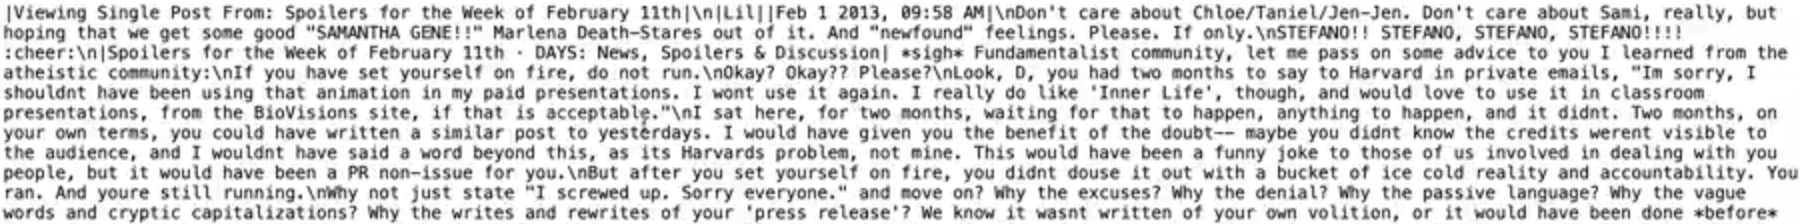

2. [BIT] 이를 utf-8으로 인코딩하면 이와 같은 0과 1의 비트로 표현할 수 있습니다. 두개의 심볼만으로 위 텍스트가 표현이 되지만, 훨씬 더 길어지게 됩니다.
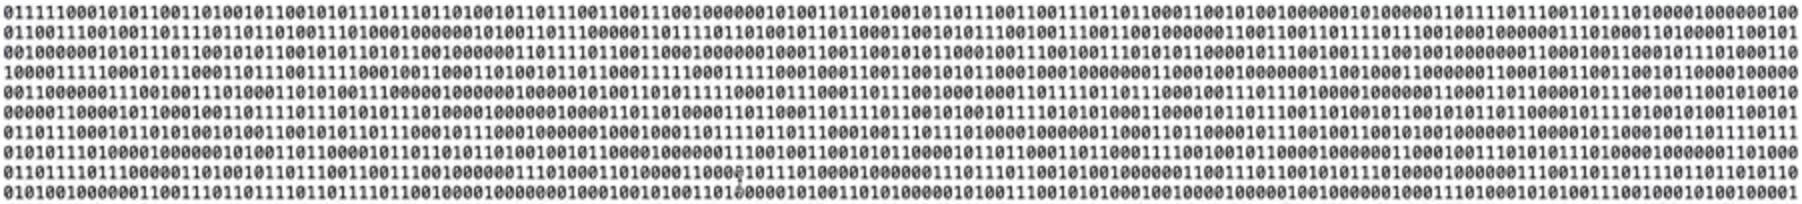

단, 언어모델에서는 유한한 심볼의 개수 뿐만 아니라, 시퀀스의 길이 또한 중요한 제약사항으로 여겨지기 때문에,
"심볼의 개수"와 "시퀀스의 길이" 사이의 trade-off 를 감안한 방식이 필요하게 됩니다. 

==> (따라서, 0과 1의 두개 심볼로만 표현하는 극도로 긴 시퀀스에서 벗어나기 위해,)

3. [BYTE] 우선, 보다 많은 심볼과 상대적으로 짧아지는 시퀀스를 찾는 NAIVE한 방법으로는, 8 BIT = 1 BYTE를 사용함으로써, 2^8 = 256개의 심볼을 사용하여 시퀀스의 길이를 1/8로 줄이는 방법을 생각할 수 있습니다.
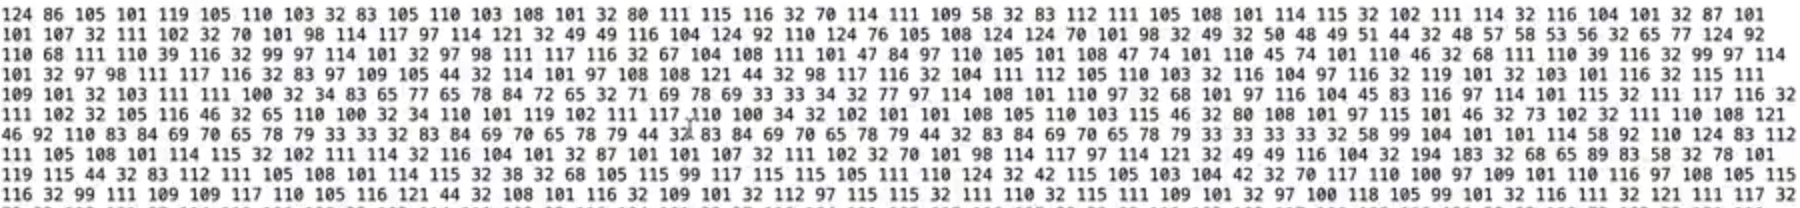

0~255까지의 숫자인데, 이를 숫자라고 생각하지 말고, 256가지의 심볼이라고 생각하는 것이 보다 직관적이다. 따라서, 모델은 아래와 같이 일테면 256가지의 Emoji를 보고 있다고 생각하는 것이 더 바람직.
(* 제가 이해하기로는 이렇게 이모지라고 생각하면 두가지 장점이 있습니다. 여기에는, 0~255라고 숫자라고 우리가 인지하다보면 크고 작음 혹은 순서 등의 의미를 우리는 습관적으로 부여하는 성향이 있는데, 이로부터 벗어날 수 있고,
 또하나는, 언어모델이 우리가 바라보는 언어와 전혀 다른 방식으로 언어를 바라본다는 점을 상기시키는 장점이 있습니다. 따라서, 왜 Strawberry에 r이 몇개있는지 카운트하는 것을 그토록 어려워하는지에 대한 보다 직관적인 힌트가 여기에 담겨있다는 장점이 있습니다 ^^; )

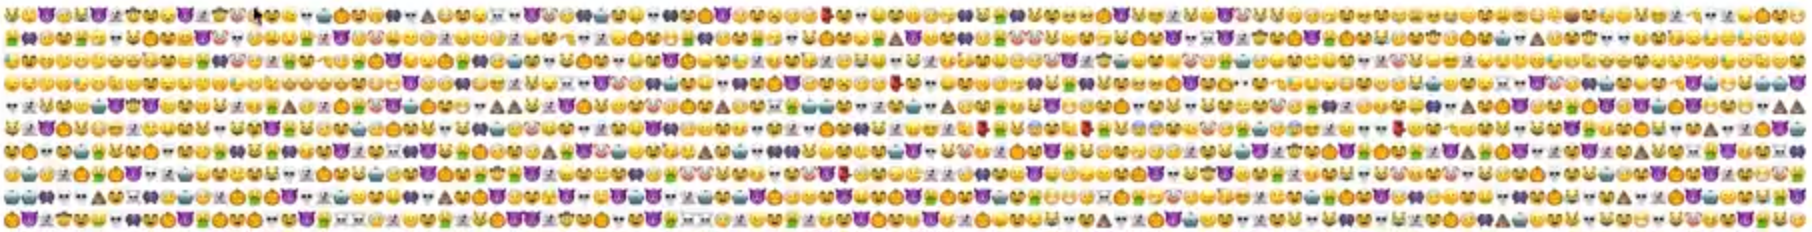

4. [ BPE (Byte Pair Encoding) 알고리즘 ] 여기에서 한걸음 더 나아가, 보다 자주 나타나는 BYTE의 묶음들을 vocabulary에 추가함으로써, 시퀀스의 길이를 보다 줄이는 BPE 알고리즘이 현재 채택되고 있습니다.
예를 들면, 116 다음에 32가 오는 경우가 많은데요, 이에 대해서 256번째의 심볼 아이디를 발급하면서 새로운 심볼을 추가한다면, 모든 116 32들에 대해서 256이라고 기입함으로써 시퀀스의 길이를 보다 짧게 만들 수 있겠죠.
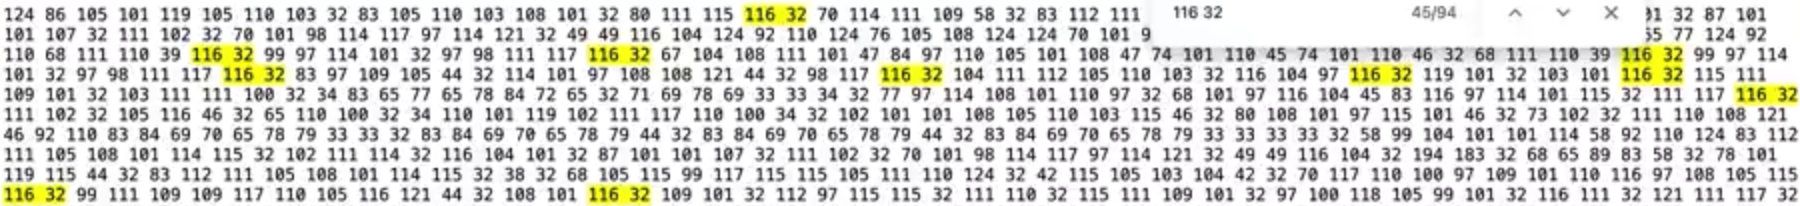

==> 이 적정 심볼 개수 (vocab_size)는 heuristic하게 결정되며, <b>GPT-4의 경우 약 10만개 (100,277)의 vocab_size를 사용하고 있습니다.</b>

이와 같이 raw text로부터 약 10만개의 심볼로 변환하는 과정을 TOKENIZATION이라고 부릅니다.

https://tiktokenizer.vercel.app/?model=cl100k_base

이를 gpt-4에서 사용하고 있는 cl100k_base 기준으로 확인해보면,
hello world의 경우, hello에 대해 15339, 공백world에 대해 1917이라는 2개의 토큰을 사용하는 것을 알 수 있음. 

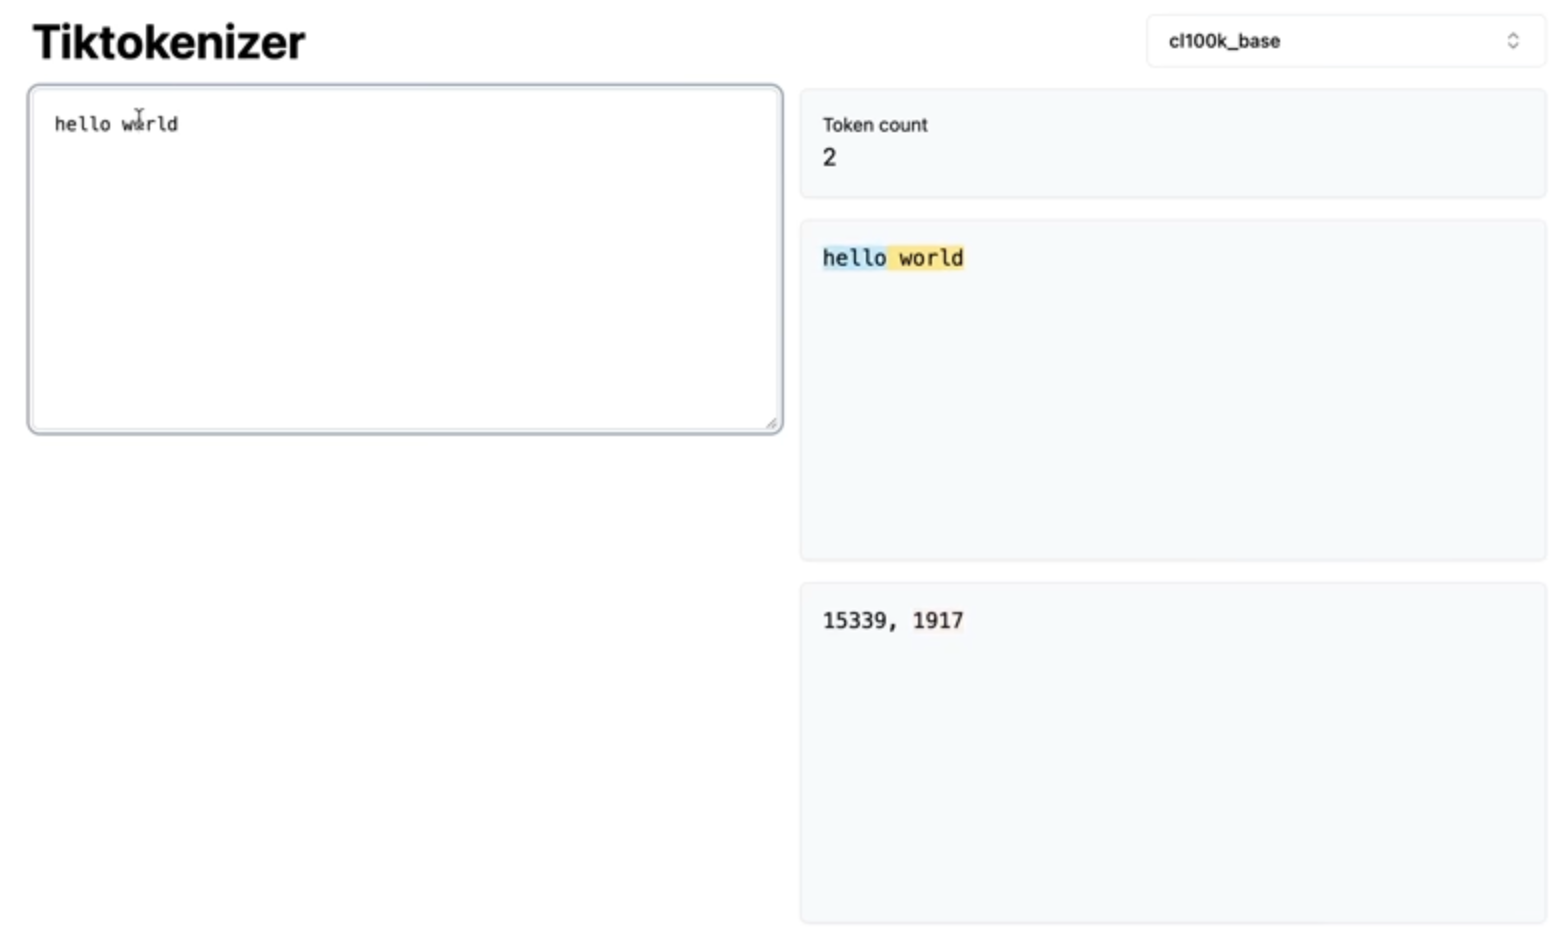



==> 이와 같은 BPE알고리즘이 적용된 tiktoken 토크나이저를 사용하여 텍스트를 인코딩하면, 위 텍스트는 다음과 같이 표현됨



FineWeb 사이트로 되돌아가보면,
데이터에서 44TB 라고 표현한 데이터의 양은, 15조개의 TOKEN길이에 해당한다는 것을 알 수 있다.

그리고, 다시한번 강조하지만, 여기있는 숫자들은 서로 다른 약 10만개의 심볼/유니크ID라는 개념으로만 이해하는 것이 바람직하다.

